# Adding Dynamic Features To Improve Energy Usage Predictions

## Part 1: Load and examine the data

In [2]:
data_bucket = '' #we should use SageMaker default s3 bucket
subfolder = 'ch07'


In [ ]:
%matplotlib inline

from dateutil.parser import parse
import json
import random
import datetime
import os

import pandas as pd                               
import boto3
import sagemaker
from sagemaker.s3 import S3Uploader
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta

role = sagemaker.get_execution_role()
sess = sagemaker.session.Session()
data_bucket = sess.default_bucket()

s3_data_path = f"s3://{data_bucket}/{subfolder}/data"
s3_output_path = f"s3://{data_bucket}/{subfolder}/output"

print(f'SageMaker exectuion role: {role},  default s3 bucket: {data_bucket}')


In this chapter we will be dealing with 5 files. Our meter readings have already been summarised into daily totals and can be found in "Meter Data.csv". We also have a "Site Categories.csv" file which records whether each site belongs to the Retail, Industrial, or Transport industries. We will use this as a static "Category" feature. There is a further file which contains time series data regarding holidays. This is "Site Holidays.csv". Finally we have maximum temperatures in "Site Maxima.csv" These will be our models "dynamic features".

In [18]:
# First we check our meter data
daily_df = pd.read_csv(f'./meter_data_daily.csv', index_col=0, parse_dates=[0])
daily_df.to_csv(f's3://{data_bucket}/{subfolder}/meter_data_daily.csv',header=False, index=False)
daily_df.index.name = None
daily_df.head()

,Site_1,Site_2,Site_3,Site_4,Site_5,Site_6,Site_7,Site_8,Site_9,Site_10,...,Site_39,Site_40,Site_41,Site_42,Site_43,Site_44,Site_45,Site_46,Site_47,Site_48
2017-11-01,1184.23,1039.1,985.95,1205.07,NaN,6684.4,1192.1,1256.1,982.6,1001.4,...,1548.92,NaN,NaN,NaN,1573.23,2871.58,2303.38,2977.41,2672.10,2298.95
2017-11-02,1210.90,1084.7,1013.91,1252.44,NaN,6894.3,1238.6,1249.4,1023.6,997.4,...,1539.52,NaN,NaN,NaN,1537.35,2890.60,2290.59,2988.84,2658.95,2112.39
2017-11-03,1247.60,1004.2,963.95,1222.40,NaN,6841.0,1174.3,1210.3,990.3,1009.3,...,1487.40,NaN,NaN,NaN,1615.69,2737.92,2289.75,2898.06,2642.38,2475.31
2017-11-04,1246.92,936.2,877.97,1157.45,NaN,6079.1,1041.2,1086.7,879.3,854.7,...,325.96,NaN,NaN,NaN,888.55,1726.20,2127.39,2617.02,1429.63,564.29
2017-11-05,1189.20,830.8,798.97,975.69,NaN,5221.5,929.4,1068.0,767.7,785.8,...,318.24,NaN,NaN,NaN,867.91,1849.85,2124.23,2320.60,726.15,554.00


In [10]:
print(daily_df.shape)
print(f'Time series starts at {daily_df.index[0]} and ends at {daily_df.index[-1]}')

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


In [19]:
category_df = pd.read_csv(f'./site_categories.csv',index_col=0).reset_index(drop=True)
category_df.to_csv(f's3://{data_bucket}/{subfolder}/site_categories.csv',header=False, index=False)

print(category_df.shape)
print(category_df.Category.unique())
category_df.head()

(48, 2)
['Retail' 'Industrial ' 'Transport']


,Site,Category
0,1,Retail
1,2,Retail
2,3,Retail
3,4,Retail
4,5,Retail


In [20]:
holiday_df = pd.read_csv(f'./site_holidays.csv', index_col=0, parse_dates=[0])
category_df.to_csv(f's3://{data_bucket}/{subfolder}/site_holidays.csv',header=False, index=False)

print(holiday_df.shape)
print(f'Time series starts at {holiday_df.index[0]} and ends at {holiday_df.index[-1]}')
holiday_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_hol,Site_2_hol,Site_3_hol,Site_4_hol,Site_5_hol,Site_6_hol,Site_7_hol,Site_8_hol,Site_9_hol,Site_10_hol,...,Site_39_hol,Site_40_hol,Site_41_hol,Site_42_hol,Site_43_hol,Site_44_hol,Site_45_hol,Site_46_hol,Site_47_hol,Site_48_hol
2018-12-22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-23,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2018-12-24,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,0,0,0,0,0,0
2018-12-25,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-26,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2018-12-27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
max_df = pd.read_csv(f'./site_maximums.csv', index_col=0, parse_dates=[0])
max_df.to_csv(f's3://{data_bucket}/{subfolder}/site_maximums.csv',header=False, index=False)
print(max_df.shape)
print(f'Time series starts at {max_df.index[0]} and ends at {max_df.index[-1]}')
max_df.loc['2018-12-22':'2018-12-27']

(485, 48)
Time series starts at 2017-11-01 00:00:00 and ends at 2019-02-28 00:00:00


,Site_1_max,Site_2_max,Site_3_max,Site_4_max,Site_5_max,Site_6_max,Site_7_max,Site_8_max,Site_9_max,Site_10_max,...,Site_39_max,Site_40_max,Site_41_max,Site_42_max,Site_43_max,Site_44_max,Site_45_max,Site_46_max,Site_47_max,Site_48_max
2018-12-22,21.5,23.4,24.9,23.1,24.9,25.2,23.4,24.9,23.4,23.9,...,33.2,20.4,20.4,24.9,21.5,21.1,21.1,18.9,18.9,40.9
2018-12-23,29.5,28.4,30.9,27.0,30.9,30.8,28.4,30.9,28.4,30.4,...,27.4,25.5,25.5,30.9,22.6,23.4,23.4,24.5,24.5,34.9
2018-12-24,33.3,35.2,36.6,35.1,36.6,37.0,35.2,36.6,35.2,36.4,...,27.0,33.8,33.8,36.6,25.4,26.8,26.8,33.9,33.9,33.6
2018-12-25,34.7,34.8,37.8,32.4,37.8,37.9,34.8,37.8,34.8,37.5,...,27.1,25.1,25.1,37.8,29.7,30.1,30.1,23.8,23.8,33.8
2018-12-26,37.5,34.8,40.0,32.8,40.0,39.5,34.8,40.0,34.8,40.1,...,27.2,30.2,30.2,40.0,30.5,31.8,31.8,23.7,23.7,29.6
2018-12-27,39.3,41.3,42.8,40.9,42.8,43.7,41.3,42.8,41.3,43.9,...,28.1,36.7,36.7,42.8,32.4,32.4,32.4,33.9,33.9,27.1


## Part 2: Get the data in the right shape

In [22]:
# We need to do this to set freq='D' on the index:
daily_df = daily_df.resample('D').sum()
daily_df = daily_df.replace([0],[None])

In [23]:
daily_df[daily_df.isnull().any(axis=1)].index

DatetimeIndex(['2017-11-01', '2017-11-02', '2017-11-03', '2017-11-04',
               '2017-11-05', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18', '2017-11-19', '2017-11-20',
               '2017-11-21', '2017-11-22', '2017-11-23', '2017-11-24',
               '2017-11-25', '2017-11-26', '2017-11-27', '2017-11-28',
               '2017-11-29', '2017-11-30'],
              dtype='datetime64[ns]', freq='D')

Some sites have missing values for November 2017. We will not impute these but instead train with missing values.
During the prediction step we will only use values from December. So daily_df is already in the right shape!

In [24]:
# How about categoricals?
print(f'{len(category_df[category_df.isnull().any(axis=1)])} sites with missing categories.')

0 sites with missing categories.


In [25]:
# Dynamic features?
print(f'{len(holiday_df[holiday_df.isnull().any(axis=1)])} days with missing holidays.')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures.')

0 days with missing holidays.
54 days with missing maximum temperatures.


In [26]:
# So we have to impute missing temperatures. Weather does not follow a weekly cycle like energu usage does,
# but pandas has a very nice way to impute missing values for this very situation:
max_df = max_df.interpolate(method='time')
print(f'{len(max_df[max_df.isnull().any(axis=1)])} days with missing maximum temperatures. Problem solved!')

0 days with missing maximum temperatures. Problem solved!


Number of time series: 48


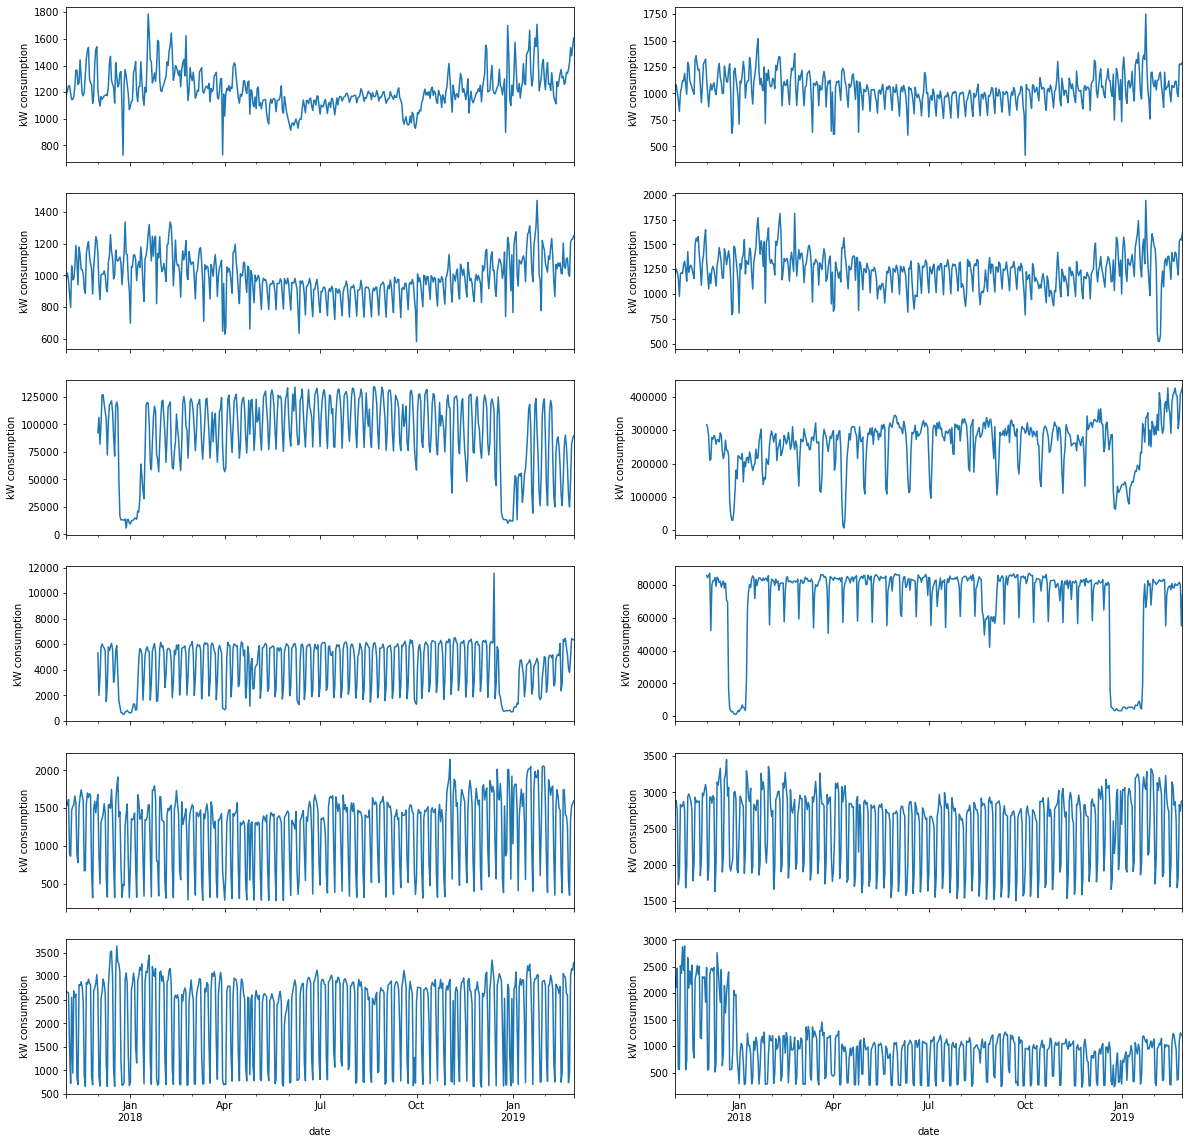

In [27]:
# Confirm visually we are dealing with the same or similar data to chapter 6:
print('Number of time series:',daily_df.shape[1])
fig, axs = plt.subplots(6, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
indices = [0,1,2,3,26,27,33,39,42,43,46,47]
for i in indices:
    plot_num = indices.index(i)
    daily_df[daily_df.columns[i]].loc["2017-11-01":"2019-02-28"].plot(ax=axx[plot_num])
    axx[plot_num].set_xlabel("date")    
    axx[plot_num].set_ylabel("kW consumption")

## Part 3: Create Train and Test Datasets

In [28]:
cats = list(category_df.Category.astype('category').cat.codes)
print(cats)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2]


In [15]:
# stations = list(station_df['Station Number'].astype('category').cat.codes)
# assert len(stations)==48
# print(stations)

In [29]:
usage_per_site = [daily_df[col] for col in daily_df.columns]

print(f'Time series covers {len(usage_per_site[0])} days.')
print(f'Time series starts at {usage_per_site[0].index[0]}')
print(f'Time series ends at {usage_per_site[0].index[-1]}') 
usage_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    1184.23
2017-11-02     1210.9
2017-11-03     1247.6
2017-11-04    1246.92
2017-11-05     1189.2
2017-11-06    1143.62
2017-11-07    1145.66
2017-11-08     1165.5
2017-11-09    1239.25
2017-11-10    1366.25
Freq: D, Name: Site_1, dtype: object

In [30]:
# Do the same for our dynamic features
hols_per_site = [holiday_df[col] for col in holiday_df.columns]
    
print(f'Time series covers {len(hols_per_site[0])} days.')
print(f'Time series starts at {hols_per_site[0].index[0]}')
print(f'Time series ends at {hols_per_site[0].index[-1]}') 
hols_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    0
2017-11-02    0
2017-11-03    0
2017-11-04    0
2017-11-05    0
2017-11-06    0
2017-11-07    0
2017-11-08    0
2017-11-09    0
2017-11-10    0
Name: Site_1_hol, dtype: int64

In [31]:
max_per_site = [max_df[col] for col in max_df.columns]
    
print(f'Time series covers {len(max_per_site[0])} days.')
print(f'Time series starts at {max_per_site[0].index[0]}')
print(f'Time series ends at {max_per_site[0].index[-1]}') 
max_per_site[0][:10]

Time series covers 485 days.
Time series starts at 2017-11-01 00:00:00
Time series ends at 2019-02-28 00:00:00


2017-11-01    20.5
2017-11-02    20.9
2017-11-03    16.2
2017-11-04    18.2
2017-11-05    22.1
2017-11-06    17.2
2017-11-07    17.5
2017-11-08    23.1
2017-11-09    28.5
2017-11-10    31.7
Name: Site_1_max, dtype: float64

In [34]:
freq = 'D'
prediction_length = 28

start_date = pd.Timestamp("2017-11-01", freq=freq)
end_training = pd.Timestamp("2019-01-31", freq=freq)
end_testing = end_training + timedelta(days=prediction_length)

print(f'End training: {end_training}, End testing: {end_testing}')

End training: 2019-01-31 00:00:00, End testing: 2019-02-28 00:00:00


In [44]:
def write_dicts_to_s3(path, data):
    basename=os.path.basename(path)
    if os.path.exists(f'./{basename}') == False:
        print(f'Write file: {basename}')
        with open(f'./{basename}', 'wb') as f:
            for d in data:
                f.write(json.dumps(d).encode("utf-8"))
                f.write("\n".encode('utf-8'))
            f.close()
    else:
        print(f'{basename} already exits')
    print(path)
    file_path=S3Uploader.upload(f'./{basename}', os.path.dirname(path))

    print(f'update load {file_path}')

In [ ]:
# NOTE: We have missing values in ts for November only.
#       Dynamic features must have numeric values for every entry.
training_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_training].tolist(),
        "dynamic_feat": [
            hols[start_date:end_training].tolist(),
            maxes[start_date:end_training].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]

test_data = [
    {
        "cat": [cat],
        "start": str(start_date),
        "target": ts[start_date:end_testing].tolist(),
        "dynamic_feat": [
            hols[start_date:end_testing].tolist(),
            maxes[start_date:end_testing].tolist(),
        ] # Note: List of lists
    }
    for cat,ts,hols,maxes in zip(cats, usage_per_site, hols_per_site, max_per_site)
]
print(f'{s3_data_path}')           
write_dicts_to_s3(f'{s3_data_path}/train/train.json', training_data)
write_dicts_to_s3(f'{s3_data_path}/test/test.json', test_data)

## Part 4: Set up session and configure model

In [47]:
s3_output_path = f's3://{data_bucket}/{subfolder}/output'
sess = sagemaker.Session()
#image_name = sagemaker.amazon.amazon_estimator.get_image_uri(sess.boto_region_name, "forecasting-deepar", "latest")

image_name = sagemaker.image_uris.retrieve(
                region=boto3.Session().region_name,
                framework='forecasting-deepar',
                version='1')

data_channels = {
    "train": f"{s3_data_path}/train/",
    "test": f"{s3_data_path}/test/"
}
np.random.seed(42)
random.seed(42)

In [48]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [49]:
class DeepARPredictor(sagemaker.predictor.Predictor):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def predict(self, ts, cat=None, dynamic_feat=None, 
                num_samples=100, return_samples=False, quantiles=["0.1", "0.5", "0.9"]):
        from datetime import timedelta
        prediction_time = ts.index[-1] +timedelta(days=1)
        quantiles = [str(q) for q in quantiles]
        req = self.__encode_request(ts, cat, dynamic_feat, num_samples, return_samples, quantiles)
        res = super(DeepARPredictor, self).predict(req)
        return self.__decode_response(res, ts.index.freq, prediction_time, return_samples)
    
    def __encode_request(self, ts, cat, dynamic_feat, num_samples, return_samples, quantiles):
        instance = series_to_dict(ts, cat if cat is not None else None, dynamic_feat if dynamic_feat else None)
        configuration = {
            "num_samples": num_samples,
            "output_types": ["quantiles", "samples"] if return_samples else ["quantiles"],
            "quantiles": quantiles
        }
        http_request_data = {
            "instances": [instance],
            "configuration": configuration
        }
        return json.dumps(http_request_data).encode('utf-8')
    
    def __decode_response(self, response, freq, prediction_time, return_samples):
        predictions =response['predictions'][0]
        prediction_length = len(next(iter(predictions['quantiles'].values())))
        prediction_index = pd.date_range(start=prediction_time, freq=freq, periods=prediction_length)        
        if return_samples:
            dict_of_samples = {'sample_' + str(i): s for i, s in enumerate(predictions['samples'])}
        else:
            dict_of_samples = {}
        return pd.DataFrame(data={**predictions['quantiles'], **dict_of_samples}, index=prediction_index)

    def set_frequency(self, freq):
        self.freq = freq
        
def encode_target(ts):
    return [x if np.isfinite(x) else "NaN" for x in ts]        

def series_to_dict(ts, cat=None, dynamic_feat=None):
    #Given a pandas.Series object, returns a dictionary encoding the time series.
    obj = {"start": str(ts.index[0]), "target": encode_target(ts)}
    if cat is not None:
        obj["cat"] = cat
    if dynamic_feat is not None:
        obj["dynamic_feat"] = dynamic_feat        
    return obj

## Part 5a: Create model without using additional datasets

First, we will establish a baseline without categorical or dynamic features. Note that this cell is commented out as you only need to run it if you want to see the MAPE without incorporating additional datasets.

In [25]:
# estimator = sagemaker.estimator.Estimator(
#     sagemaker_session=sess,
#     image_name=image_name,
#     role=role,
#     train_instance_count=1,
#     train_instance_type='ml.c5.2xlarge', # $0.476 per hour as of Jan 2019.
#     base_job_name='ch7-energy-usage-baseline',
#     output_path=s3_output_path
# )

# estimator.set_hyperparameters(
#     cardinality='ignore', # DISABLES CATEGORICALS FOR BASELINE
#     context_length="90",
#     prediction_length=str(prediction_length),
#     time_freq=freq,
#     epochs="400",
#     early_stopping_patience="40",
#     mini_batch_size="64",
#     learning_rate="5E-4",
#     num_dynamic_feat="ignore", # DISABLE DYNAMIC FEATURES FOR BASELINE
# )

# estimator.fit(inputs=data_channels, wait=True)

# endpoint_name = 'energy-usage-baseline'

# try:
#     sess.delete_endpoint(
#         sagemaker.predictor.RealTimePredictor(endpoint=endpoint_name).endpoint)
#     print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
#     from time import sleep
#     sleep(30)
# except:
#     pass

# predictor = estimator.deploy(
#     initial_instance_count=1,
#     instance_type='ml.m5.large',
#     predictor_cls=DeepARPredictor,
#     endpoint_name=endpoint_name)

# # Gather 28 day predictions for all timeseries
# usages = [ts[end_training+1:end_training+28].sum() for ts in usage_per_site]

# predictions= []
# for s in range(len(usage_per_site)):
#     # call the end point to get the 28 day prediction
#     predictions.append(
#         predictor.predict(
#             ts=usage_per_site[s][start_date+30:end_training],
#         )['0.5'].sum()
#     )
    
# print(f'MAPE: {round(mape(usages, predictions),1)}%')    

## Part 5b: Model incorporating additional datasets

In [ ]:
%%time
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sess,
    image_uri=image_name,
    role=role,
    instance_count=1,
    instance_type='ml.c5.2xlarge', # $0.476 per hour as of Jan 2019.
    base_job_name='ch7-energy-usage-dynamic',
    output_path=s3_output_path
)

estimator.set_hyperparameters(
    context_length="90",
    prediction_length=str(prediction_length),
    time_freq=freq,
    epochs="400",
    early_stopping_patience="40",
    mini_batch_size="64",
    learning_rate="5E-4",
    num_dynamic_feat=2,
)

estimator.fit(inputs=data_channels, wait=True)

## Part 6. Making predictions from the model that incorporates additional datasets

In [53]:
endpoint_name = 'energy-usage-dynamic'

try:
    predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)
    predictor.endpoint_context()
    sess.delete_endpoint(endpoint_name)
    print('Warning: Existing endpoint and configuration deleted to make way for your new endpoint.')
except:
    pass

In [57]:
%%time
from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import IdentitySerializer

predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.m5.large',
    predictor_cls=DeepARPredictor,
    endpoint_name=endpoint_name,
    serializer=IdentitySerializer(content_type="application/json"),
    deserializer=JSONDeserializer()
)

------!CPU times: user 124 ms, sys: 8.11 ms, total: 132 ms
Wall time: 3min 1s


In [58]:
# Test prediction: (Delete endpoint configuration if retrying)
predictor.predict(
    cat=[cats[0]],
    ts=usage_per_site[0][start_date+timedelta(days=30):end_training],
     dynamic_feat=[
             hols_per_site[0][start_date+timedelta(days=30):end_training+timedelta(days=28)].tolist(),
             max_per_site[0][start_date+timedelta(days=30):end_training+timedelta(days=28)].tolist(),
         ],
    quantiles=[0.1, 0.5, 0.9]
).head()

,0.1,0.5,0.9
2019-02-01,1074.077026,1199.165894,1315.343506
2019-02-02,1085.997681,1220.086426,1335.885986
2019-02-03,1201.941895,1333.032959,1501.779053
2019-02-04,1168.491577,1306.567627,1448.109009
2019-02-05,1144.640869,1286.195068,1397.112427


In [60]:
# Gather 28 day predictions for all timeseries
usages = [ts[end_training+timedelta(days=1):end_training+timedelta(days=28)].sum() for ts in usage_per_site]

predictions= []
for s in range(len(usage_per_site)):
    # call the end point to get the 28 day prediction
    predictions.append(
        predictor.predict(
            cat=[cats[s]],
            ts=usage_per_site[s][start_date+timedelta(days=30):end_training],
            dynamic_feat=[
                hols_per_site[s][start_date+timedelta(days=30):end_training+timedelta(days=28)].tolist(),
                max_per_site[s][start_date+timedelta(days=30):end_training+timedelta(days=28)].tolist(),
             ]
        )['0.5'].sum()
    )

for p,u in zip(predictions,usages):
    print(f'Predicted {p} kwh but usage was {u} kwh.')

Predicted 35931.837524414004 kwh but usage was 37068.36 kwh.
Predicted 29994.076782226704 kwh but usage was 30693.799999999992 kwh.
Predicted 28483.0994262697 kwh but usage was 30511.63000000001 kwh.
Predicted 36798.4411010745 kwh but usage was 34640.020000000004 kwh.
Predicted 30055.1822509766 kwh but usage was 31308.799999999996 kwh.
Predicted 201054.130859375 kwh but usage was 214708.80000000005 kwh.
Predicted 22029.462402343797 kwh but usage was 26765.299999999996 kwh.
Predicted 19261.096343994002 kwh but usage was 21487.999999999996 kwh.
Predicted 31577.797851562304 kwh but usage was 32996.99999999999 kwh.
Predicted 15779.747589111399 kwh but usage was 16920.5 kwh.
Predicted 34454.1772460937 kwh but usage was 34510.01999999999 kwh.
Predicted 34115.2083740235 kwh but usage was 35310.399999999994 kwh.
Predicted 18262.2071533206 kwh but usage was 19524.100000000006 kwh.
Predicted 31144.7039794923 kwh but usage was 33006.7 kwh.
Predicted 33959.2628784179 kwh but usage was 35398.200000

In [61]:
print(f'MAPE: {round(mape(usages, predictions),1)}%')

MAPE: 11.1%


That's a really impressive improvement from 21%. What does this look like visually?

In [64]:
def plot(
    predictor, 
    site_id,
    end_training=end_training, 
    plot_weeks=12,
    confidence=80
):
    low_quantile = 0.5 - confidence * 0.005
    up_quantile = confidence * 0.005 + 0.5
    target_ts = usage_per_site[site_id][start_date+timedelta(days=30):]
    dynamic_feats = [
            hols_per_site[site_id][start_date+timedelta(days=30):].tolist(),
            max_per_site[site_id][start_date+timedelta(days=30):].tolist(),
        ]
        
    plot_history = plot_weeks * 7

    fig = plt.figure(figsize=(20, 3))
    ax = plt.subplot(1,1,1)
    
    prediction = predictor.predict(
        cat = [cats[site_id]],
        ts=target_ts[:end_training],
        dynamic_feat=dynamic_feats,
        quantiles=[low_quantile, 0.5, up_quantile])
                
    target_section = target_ts[end_training-timedelta(days=plot_history):end_training+timedelta(days=prediction_length)]
    target_section.plot(color="black", label='target')
    
    ax.fill_between(
        prediction[str(low_quantile)].index, 
        prediction[str(low_quantile)].values, 
        prediction[str(up_quantile)].values, 
        color="b", alpha=0.3, label='{}% confidence interval'.format(confidence)
    )  
    
    ax.set_ylim(target_section.min() * 0.5, target_section.max() * 1.5)

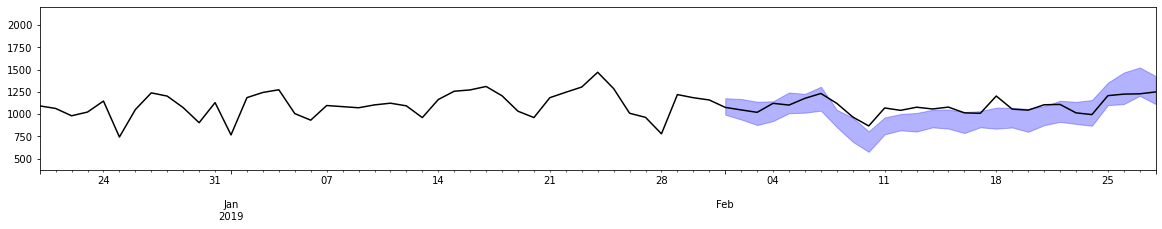

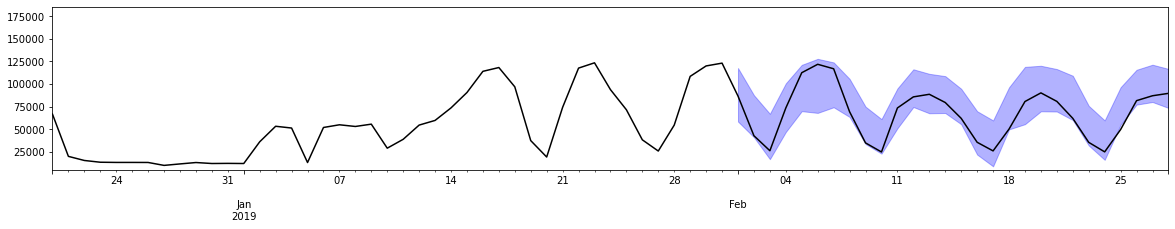

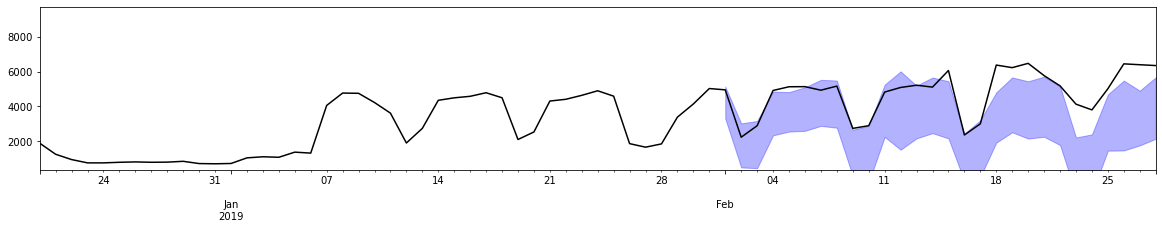

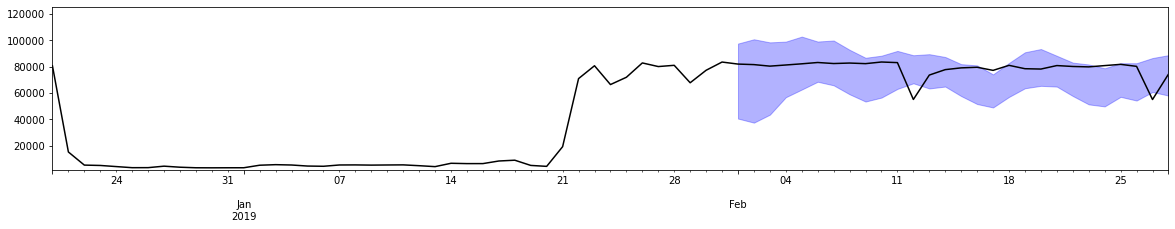

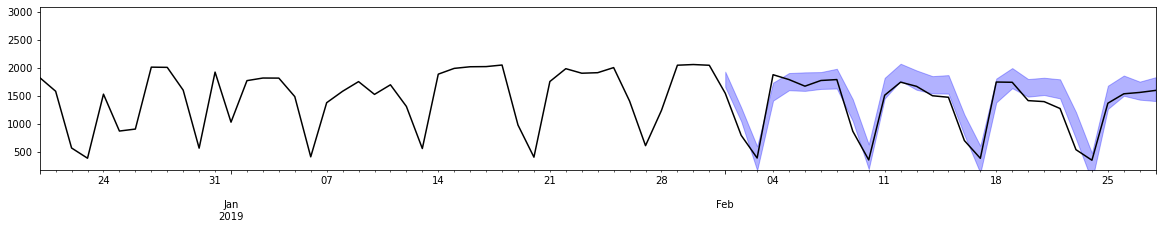

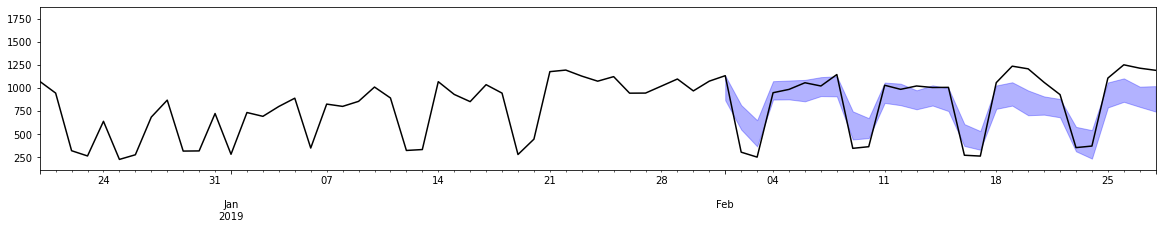

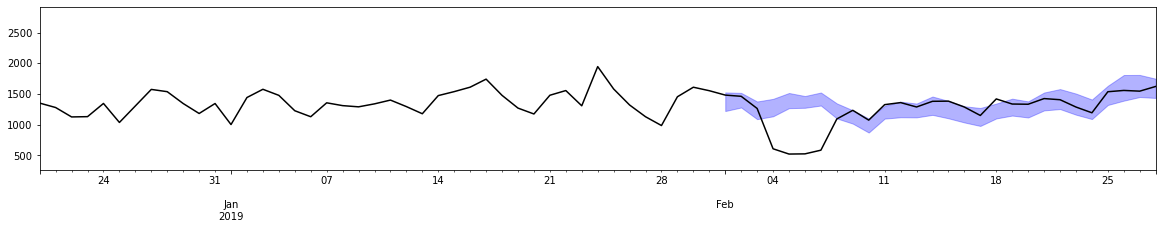

In [65]:
# Plot 4 of each category:
indices = [2,26,33,39,42,47,3]
for i in indices:
    plot_num = indices.index(i)
    plot(
        predictor,
        site_id=i,
        plot_weeks=6,
        confidence=80
    )

## Part 7. Remove the Endpoints

In [56]:
# Remove the Endpoint
# Comment out this cell to remove the endpoint if you want the endpoint to exist after "run all"

# sess.delete_endpoint('energy-usage-baseline')
# sess.delete_endpoint('energy-usage-dynamic')
sess.delete_endpoint(endpoint_name)
